### Options pricing  using black scholes
key variables are: 
- S: current stock price
- K: strike price
- T: time to expiration in years
- r: risk-free interest rate        
- sigma: volatility of the underlying stock
- d1: d1 = (ln(S/K) + (r + sigma^2/2) * T) / (sigma * sqrt(T))
- d2: d2 = d1 - sigma * sqrt(T)

In [1]:
import math
from scipy.stats import norm

In [2]:
# define the variables
S = 45  # underlying price
K = 40  # strike price - at the time of option expiration, i have the option to purchase the stock at $40, regardless of its market price.
T = 0.5    # time to expiration in years - 6 months
r = 0.1  # risk-free interest rate
vol = 0.2  # volatility of the underlying stock

Calculate D1 
The formula for D1 is:
- D1 = (ln(S/K) + (r + sigma^2/2) * T) / (sigma * sqrt(T))

In [3]:
d1 = (math.log(S / K) + (r + 0.5 * vol ** 2 ) * T) / (vol * math.sqrt(T))

Calculate D2
The formula for D2 is:
- D2 = D1 - sigma * sqrt(T)

In [4]:
d2 = d1 - ( vol * math.sqrt(T) )

Calculate Call Option Price
The formula for the call option price (C) is:
- C = S * N(d1) - K * e^(-rT) * N(d2)

In [5]:
C = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)

Calculate [Put Option Price]
The formula for the put option price (P) is:
- P = K * e^(-rT) * N(-d2) - S * N(-d1)

In [6]:
P = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

Print Results

In [7]:
print('the value of d1 is:', round(d1, 4))
print('the value of d2 is:', round(d2, 4))
print('the call option price is: $', round(C, 2))
print('the put option price is: $', round(P, 2))

the value of d1 is: 1.2571
the value of d2 is: 1.1157
the call option price is: $ 7.29
the put option price is: $ 0.34


### Value at Risk (VaR) Calculation
Value at Risk (VaR) is a statistical measure used to assess the potential loss in value of a portfolio over a defined period for a given confidence interval. It provides an estimate of the maximum expected loss that an investment portfolio could face under normal market conditions.

In [8]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [9]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=years * 365)

In [10]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate, auto_adjust=False)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  SPY        BND         GLD        QQQ        VTI
Date                                                              
2010-11-15  91.612175  52.877586  132.419998  45.850746  47.233894
2010-11-16  90.184906  53.052883  130.970001  45.096947  46.482338
2010-11-17  90.230667  53.065914  130.380005  45.228413  46.559006
2010-11-18  91.558708  53.065914  132.089996  45.955910  47.210892
2010-11-19  91.810585  53.078869  132.199997  45.990997  47.402630


Calculate daily log returns

In [11]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()
print(log_returns.head())

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2010-11-16 -0.015702  0.003310 -0.011010 -0.016577 -0.016039
2010-11-17  0.000507  0.000246 -0.004515  0.002911  0.001648
2010-11-18  0.014611  0.000000  0.013030  0.015957  0.013904
2010-11-19  0.002747  0.000244  0.000832  0.000763  0.004053
2010-11-22 -0.000832  0.002931  0.009636  0.008351  0.000161


Create a function that will be used to caluclate portfolio expected return

In [12]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights)

Create a function that will be used to calculate portfolio standard deviation

In [13]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Create a Covariance Matrix for all the securities

In [14]:
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD       QQQ       VTI
SPY  1.175060e-04  8.695734e-07  0.000004  0.000132  0.000120
BND  8.695734e-07  9.603450e-06  0.000009  0.000002  0.000001
GLD  4.356955e-06  9.106014e-06  0.000098  0.000006  0.000005
QQQ  1.319455e-04  1.651961e-06  0.000006  0.000171  0.000134
VTI  1.196604e-04  1.084720e-06  0.000005  0.000134  0.000123


Create an equally weighted portfolio and find total portfolio expected return and standard deviation

In [15]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)] * len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation(weights, cov_matrix)

Create a function that gives a random Z value from a standard normal distribution

In [16]:
def random_z_score():
    return np.random.normal(0,1)

Create a function to calculate scenarioGainLoss

In [17]:
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

Run 10000 simulations

In [18]:
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

Specify a confidence level and calculate VaR

In [19]:
confidence_interval = 0.95
VaR = -np.percentile(scenarioReturn, (1 - confidence_interval) * 100)
print(VaR)

46399.964304387984


Plot the result of 10000 scenarios

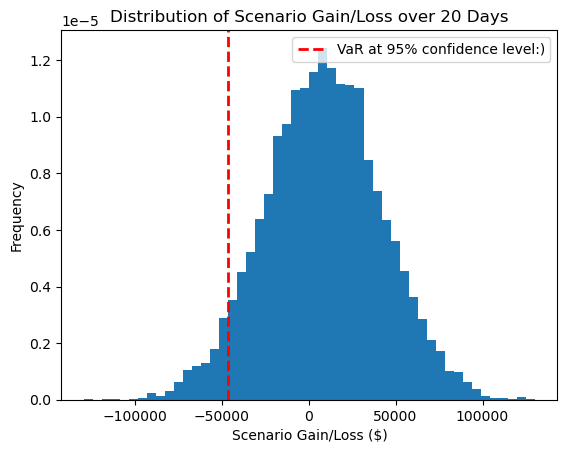

In [20]:
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Scenario Gain/Loss over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level:)')
plt.legend()
plt.show()